# Programming Exercise 4

In [1]:
import numpy as np

import scipy.sparse as sp
import scipy.sparse.linalg as spla

from scipy.spatial import Delaunay

import matplotlib.pyplot as plt

In [2]:
def christmas_tree_mesh(k, tree_levels = 4):
    ## Generates a mesh of a Christmas tree domain
    ##       width of the base:   [-0.5 - 0.5*tree_levels, 0.5 + 0.5*tree_levels]
    ##       height of the tree:  [0., 2*tree_levels]
    
    ## Returns: nodes:          an array with the coordinates of every node, i.e. nodes[k] = [x_k, y_k]
    ##          elements:       an array of the elements, each of them represented by the indices (in nodes) of its 3 vertices
    ##          boundary_nodes: a list of the indices (in nodes) of those nodes in the boundary of the domain
    ##          boundary_edges: a list of boundary edges, each of them being a pair of node indices
    
    total_height = tree_levels * 2.
    
    xh = 1. / (2**k)
    yh = 2. * xh
    
    x_at_level = {}
    y_at_level = {}
    elements_at_level = {}
    boundary_nodes_at_level = {}
    boundary_edges_at_level = {}
    
    node_idx = 1
    last_boundary_node_left = 0
    last_boundary_node_right = 0
    
    for L in range(tree_levels):
        if L == 0:
            # Initialize with the top node
            x_at_level[L] = [0.]
            y_at_level[L] = [2.*tree_levels]
            boundary_nodes_at_level[L] = [0]
        else:
            boundary_nodes_at_level[L] = []
            
            # Initialize with the last 1 + L*2**k nodes from previous level
            q = 1 + L*2**k
            x_at_level[L] = x_at_level[L-1][-q:]
            y_at_level[L] = y_at_level[L-1][-q:]
        
        boundary_edges_at_level[L] = []
        
        for i in range(1, 2**k + 1):
            yi = total_height - L*2. - i*yh
            
            boundary_edges_at_level[L].append([node_idx, last_boundary_node_left])
            boundary_edges_at_level[L].append([node_idx+1, last_boundary_node_right])
            
            boundary_nodes_at_level[L].append(node_idx)
            boundary_nodes_at_level[L].append(node_idx+1)
            
            last_boundary_node_left = node_idx
            last_boundary_node_right = node_idx + 1
            
            for j in reversed(range(1, 1 + i + L * 2**(k-1))):
                y_at_level[L].append(yi)
                y_at_level[L].append(yi)
                
                x_at_level[L].append(-j * xh)
                x_at_level[L].append(j * xh)
                
                node_idx += 2
            
            y_at_level[L].append(yi)
            x_at_level[L].append(0.)
            node_idx += 1
        
        if L == (tree_levels - 1):
            # The last (2**k) * (L+2) - 1 are also boundary nodes
            q = (2**k) * (L+2) - 1
            
            for idx in range(node_idx - q, node_idx):
                boundary_nodes_at_level[L].append(idx)
                boundary_edges_at_level[L].append([idx, idx - 2])
                
            boundary_edges_at_level[L].append([node_idx - 1, node_idx - 2])
        else:
            # The first 2**k from the last (2**k) * (L+2) - 1 are also boundary nodes
            q = (2**k) * (L+2) - 1
            for idx in range(node_idx - q, node_idx - q + 2**k):
                boundary_nodes_at_level[L].append(idx)
                
                boundary_edges_at_level[L].append([idx, idx - 2])
            
            last_boundary_node_left += 2**k
            last_boundary_node_right += 2**k
        
        elements_at_level[L] = Delaunay(np.hstack([np.asarray(x_at_level[L])[:, np.newaxis],
                                                   np.asarray(y_at_level[L])[:, np.newaxis]])).simplices
        
    x = x_at_level[0]
    y = y_at_level[0]
    elements = elements_at_level[0]
    boundary_nodes = boundary_nodes_at_level[0]
    boundary_edges = boundary_edges_at_level[0]
    
    for L in range(1, tree_levels):
        # Ignore the first 1 + L*2**k nodes
        q = 1 + L*2**k
        elements_at_level[L] += len(x) - q
        boundary_nodes += boundary_nodes_at_level[L]
        boundary_edges += boundary_edges_at_level[L]
        
        x += x_at_level[L][q:]
        y += y_at_level[L][q:]
        
        elements = np.concatenate((elements, elements_at_level[L]))
    
    nodes = np.hstack([np.asarray(x)[:, np.newaxis], np.asarray(y)[:, np.newaxis]])
    
    return nodes, elements, boundary_nodes, boundary_edges

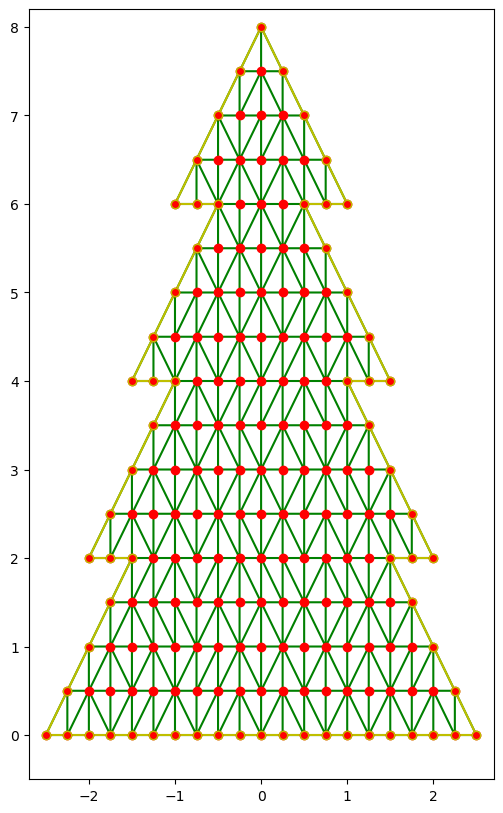

In [3]:
# Visualize the mesh
nodes, elements, boundary_nodes, boundary_edges = christmas_tree_mesh(2)

fig = plt.figure(figsize=(6,10))

plt.triplot(nodes[:,0], nodes[:,1], elements, color='g') # Triangles

# Boundary edges
for j, s in enumerate(boundary_edges):
    edge = nodes[s]
    plt.plot(edge[:,0], edge[:,1], 'y')

plt.plot(nodes[:,0], nodes[:,1], 'ro') # Nodes
plt.plot(nodes[boundary_nodes,0], nodes[boundary_nodes,1], 'yo', mfc='none') # Boundary nodes

plt.xlim(-2.7, 2.7); plt.ylim(-0.5, 8.2)
plt.show()